## VGG16 Face

In [51]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### prepare Data

In [54]:
BASE_DIR = 'stroke-normal_dataset'
train_dir = os.path.join(BASEPATH+'\stroke-normal_dataset_processed)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 20,
                                    horizontal_flip = True,
                                    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(224, 224),
                                                    subset='training')

# val_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(224, 224),
                                                    subset='validation')

Found 5420 images belonging to 2 classes.
Found 1353 images belonging to 2 classes.


### extract

1/1 [==============================] - 0s 115ms/step


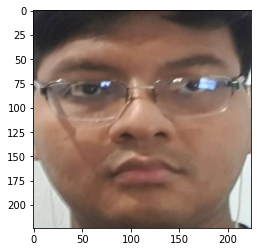

In [23]:
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	image.save('face.jpg')
	return image

# load the photo and extract the face
face_extract = extract_face('622351.jpg')
# plot the extracted face
pyplot.imshow(face_extract)
# show the plot
pyplot.show()


In [27]:
CHANNELS = 3
HEIGHT = 224
WIDTH = 224
def prepareImg(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [HEIGHT, WIDTH])
    image_normalized = image_resized / 255.0
    image_for_model = np.expand_dims(image_normalized, axis=0)
    return image_for_model

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [41]:
#Define VGG_FACE_MODEL architecture
def VGGPretrained(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

# Load VGG Face model weights
vgg_model = VGGPretrained('vgg_face_weights.h5')
# Remove Last Softmax layer and get model upto last flatten layer with outputs 2622 units
faceEmbedModel=Model(inputs=vgg_model.layers[0].input,outputs=vgg_model.layers[-2].output)
faceEmbedModel.trainable = False
faceEmbedModel.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_97_input (In  [(None, 224, 224, 3)]    0         
 putLayer)                                                       
                                                                 
 zero_padding2d_97 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_184 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_98 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_185 (Conv2D)         (None, 224, 224, 64)      36928     
                                                          

In [42]:
def output_of_last_layer(model,layer_name):
  if(layer_name == ''):
      return model.output
  last_desired_layer = model.get_layer(layer_name)
  # print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  # print('last layer output: ', last_output)

  return last_output

In [58]:
inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, CHANNELS))
x = preprocess_input(inputs)
x = faceEmbedModel(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_8   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model_35 (Functional)       (None, 2622)              145002878 
                                                                 
 dense_69 (Dense)            (None, 128)               335744    
                                                                 
 batch_normalization_18 (Bat  (None, 128)              512

In [49]:
CHECKPOINT_PATH = "model_checkpoint/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH+'chk',
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [67]:
history_train = model.fit(train_generator, validation_data=validation_generator, epochs=4, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/4
170/170 [==============================] - 74s 430ms/step - loss: 0.4325 - accuracy: 0.8485 - val_loss: 0.4244 - val_accuracy: 0.8492
Epoch 2/4
170/170 [==============================] - 74s 437ms/step - loss: 0.4353 - accuracy: 0.8483 - val_loss: 0.4251 - val_accuracy: 0.8492
Epoch 3/4
170/170 [==============================] - 76s 447ms/step - loss: 0.4319 - accuracy: 0.8489 - val_loss: 0.4249 - val_accuracy: 0.8492
Epoch 4/4
170/170 [==============================] - 75s 439ms/step - loss: 0.4335 - accuracy: 0.8485 - val_loss: 0.4247 - val_accuracy: 0.8492


In [68]:
history_train

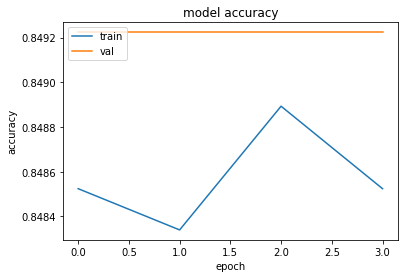

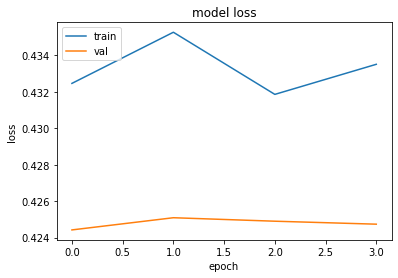

In [70]:
plt.figure()
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['droopy', 'normal']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

43/43 [==============================] - 15s 348ms/step
Confusion Matrix
[[ 204    0]
 [1149    0]]
Classification Report
              precision    recall  f1-score   support

      droopy       0.15      1.00      0.26       204
      normal       0.00      0.00      0.00      1149

    accuracy                           0.15      1353
   macro avg       0.08      0.50      0.13      1353
weighted avg       0.02      0.15      0.04      1353



c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(prediction[class_name],test[class_name])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [29]:
# convert one face into samples
face_extract = prepareImg('face.jpg')
# face_extract.shape
prediction = model.predict(face_extract)

1/1 [==============================] - 0s 21ms/step


In [32]:
len(prediction[0])

2622

## reference

In [ ]:
# Load saved model
classifier_model=tf.keras.models.load_model('face_classifier_model.h5')

dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

# Label names for class numbers
person_rep={0:'Lakshmi Narayana',
 1: 'Vladimir Putin',
 2: 'Angela Merkel',
 3: 'Narendra Modi',
 4: 'Donald Trump',
 5: 'Xi Jinping'}

file_path=input("Path to image with file size < 100 kb ? ")

img=cv2.imread(file_path)
if img is None or img.size is 0 :
  print("Please check image path or some error occured")
  exit()

persons_in_img=[]
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect Faces
rects=dnnFaceDetector(gray,1)
left,top,right,bottom=0,0,0,0
for (i,rect) in enumerate(rects):
  # Extract Each Face
  left=rect.rect.left() #x1
  top=rect.rect.top() #y1
  right=rect.rect.right() #x2
  bottom=rect.rect.bottom() #y2
  width=right-left
  height=bottom-top
  img_crop=img[top:top+height,left:left+width]
  cv2.imwrite(os.getcwd()+'/crop_img.jpg',img_crop)

  # Get Embeddings
  crop_img=load_img(os.getcwd()+'/crop_img.jpg',target_size=(224,224))
  crop_img=img_to_array(crop_img)
  crop_img=np.expand_dims(crop_img,axis=0)
  crop_img=preprocess_input(crop_img)
  img_encode=vgg_face(crop_img)

  # Make Predictions
  embed=K.eval(img_encode)
  person=classifier_model.predict(embed)
  name=person_rep[np.argmax(person)]
  os.remove(os.getcwd()+'/crop_img.jpg')
  cv2.rectangle(img,(left,top),(right,bottom),(0,255,0), 2)
  img=cv2.putText(img,name,(left,top-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
  img=cv2.putText(img,str(np.max(person)),(right,bottom+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
  persons_in_img.append(name)
# Save images with bounding box,name and accuracy 
cv2.imwrite(os.getcwd()+'/recognized_img.jpg',img)

#Person in image
print('Person(s) in image is/are:')
print(persons_in_img)

plt.figure(figsize=(8,4))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()